In [1]:
import numpy as np
import pickle

import torch
from torch import nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
import os

data_path = '/content/drive/MyDrive/CS7643Group/Dataset/training/parsed_data_final_srishti.pkl'
with open(data_path, "rb") as file:
  data = pickle.load(file)

print(data.shape)

data = data[:, :-1, :]

#This is for original only (vehicle features only)
data = data[:, :, 1:6]


print(f"Shape of full dataset: {data.shape}")
# print(data[0])
X_train = data[:int(0.8*len(data)), :80, :]
X_val = data[int(0.8*len(data)): , :80, :]

y_train = data[:int(0.8*len(data)), 80:, :]
y_val = data[int(0.8*len(data)): , 80:, :]

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(2933, 91, 14)
Shape of full dataset: (2933, 90, 13)
(2346, 80, 13) (587, 80, 13) (2346, 10, 13) (587, 10, 13)


# Initial Base Model Implementation

1.   Vehicle features only



Epoch [1/150], Training Loss: 5144.1659, LR: 0.009999
Validation Loss: 2425.2336
Epoch [2/150], Training Loss: 4805.4871, LR: 0.009996
Validation Loss: 2499.8541
Epoch [3/150], Training Loss: 4882.0172, LR: 0.009990
Validation Loss: 2467.3916
Epoch [4/150], Training Loss: 4841.3495, LR: 0.009982
Validation Loss: 2407.5698
Epoch [5/150], Training Loss: 4698.7007, LR: 0.009973
Validation Loss: 2349.1063
Epoch [6/150], Training Loss: 4688.0401, LR: 0.009961
Validation Loss: 2341.7350
Epoch [7/150], Training Loss: 4662.5342, LR: 0.009946
Validation Loss: 2295.3337
Epoch [8/150], Training Loss: 4642.6165, LR: 0.009930
Validation Loss: 2361.6328
Epoch [9/150], Training Loss: 4524.8693, LR: 0.009911
Validation Loss: 2306.4014
Epoch [10/150], Training Loss: 4435.3228, LR: 0.009891
Validation Loss: 2296.8209
Epoch [11/150], Training Loss: 4396.2427, LR: 0.009868
Validation Loss: 2213.3388
Epoch [12/150], Training Loss: 4322.7322, LR: 0.009843
Validation Loss: 2193.8080
Epoch [13/150], Training 

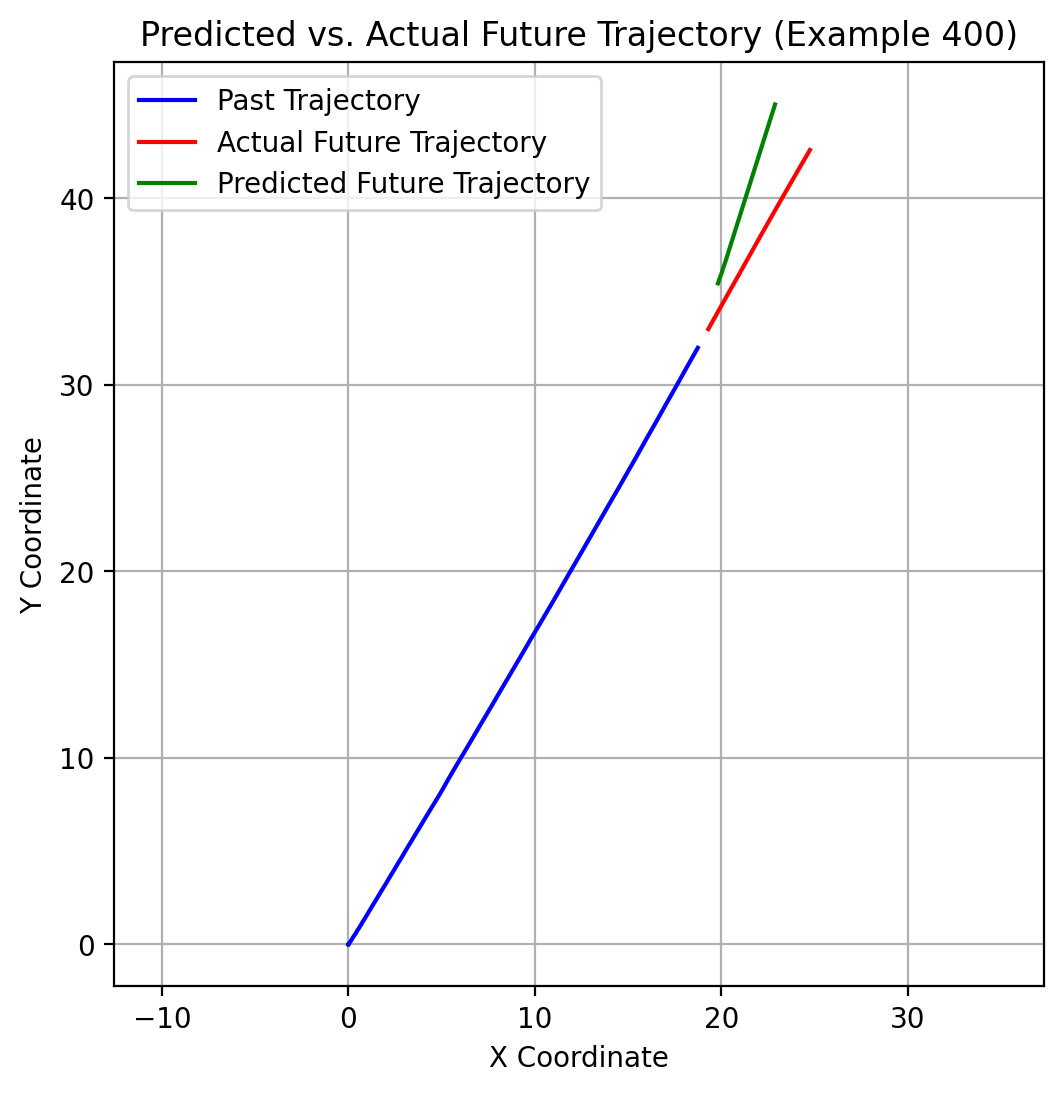

In [8]:
import torch
import torch.nn as nn

class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1):  # Set default n to 10
        super(TrajectoryLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_features * output_timesteps)
        self.output_features = output_features
        self.output_timesteps = output_timesteps

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        _, (hn, _) = self.lstm(x)
        # hn: (num_layers, batch_size, hidden_size)
        # want to take the last layer so that you are left with (batch_size, hidden_size)
        out = self.fc(hn[-1])
        return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, 10, input_size)


class TrajectoryLoss(nn.Module):
    def __init__(self):
        super(TrajectoryLoss, self).__init__()
        self.max_acceleration = 3.0

    def forward(self, predictions, targets, last_input_state, dt=0.1):
        # Reconstruct trajectory from velocities
        pred_velocity = predictions[:, :, :]
        cum_disp = torch.cumsum(pred_velocity * dt, dim=1)
        # print(pred_velocity.shape)
        # (32, 10, 2)
        pred_position = cum_disp + last_input_state.unsqueeze(1)
        # print(pred_position.shape)

        target_position = targets[:, :, :2]
        target_velocity = targets[:, :, 2:4]

        # Calculate MSE for position

        position_loss = F.mse_loss(pred_position, target_position)
        velocity_loss = F.mse_loss(pred_velocity, target_velocity)
        terminal_position_loss = F.mse_loss(pred_position[:, -1, :], target_position[:, -1, :]) + F.mse_loss(pred_position[:, 0, :], target_position[:, 0, :])
        smoothness_loss = self.smoothness_loss(pred_position)

        total_loss = position_loss + velocity_loss + smoothness_loss + 2 * terminal_position_loss
        return total_loss

    def acceleration_limit_loss(self, pred_velocity, dt=0.1):
        # Ensure accelerations remain within feasible limits by penalizing large changes in velocity
        approx_acceleration = (pred_velocity[:, :-1, :] - pred_velocity[:, 1:, :]) / dt  # Difference between consecutive velocities
        acceleration_norm = torch.norm(approx_acceleration, dim=2)
        excess_acceleration = torch.clamp(acceleration_norm - self.max_acceleration, min=0.0)
        return torch.mean(excess_acceleration ** 2)


    def smoothness_loss(self, pred_position):
        # Calculate the difference between consecutive positions
        diff = pred_position[:, :-1, :] - pred_position[:, 1:, :]
        smoothness = torch.norm(diff, dim=2)
        return torch.mean(smoothness)
from torch.utils.data import DataLoader, TensorDataset
import torch

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10):
    criterion = TrajectoryLoss()  # Use the custom loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0  # Initialize training loss for the epoch
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Compute loss using the custom loss function
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            epoch_train_loss += loss.item()  # Accumulate training loss

        # Update learning rate based on the cosine decay schedule
        scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store training loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0  # Initialize validation loss for the epoch
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()  # Accumulate validation loss

            # Average validation loss for the epoch
            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)  # Store validation loss
            print(f'Validation Loss: {avg_val_loss:.4f}')

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Initialize model
input_size = X_train.shape[2]  # Number of features
hidden_size = 64  # You can adjust this

# hidden_size = 32  # You can adjust this

# input_size = 5
model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=4).to("cuda")

# model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1).to("cuda")


# Train the model with cosine decay learning rate


train_model(model, train_loader, val_loader, num_epochs=150, initial_lr=1e-2, T_max=50)


x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")

with torch.no_grad():
    outputs = model(x)
    cum_disp = torch.cumsum(outputs * 0.1, dim=1)
    pred_position = cum_disp + y[:, 0, :2].unsqueeze(1)

    distances = torch.norm(pred_position - y[:, :, :2], dim=2)
    mean_ade = distances.mean().item()
#LSTM
print("Mean ADE:", mean_ade)



# Choose a random example from the validation dataset
example_index = 400 # np.random.randint(0, len(X_val))
# 300 produces no movement for x and y
# 250 produces an erratic motion for x and y (curvy)

past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()



# Plot the past trajectory, actual future trajectory, and predicted future trajectory
#LSTM
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# print(past_traj[:, :2])

# Transformer Architecture




1.   Vehicle features only



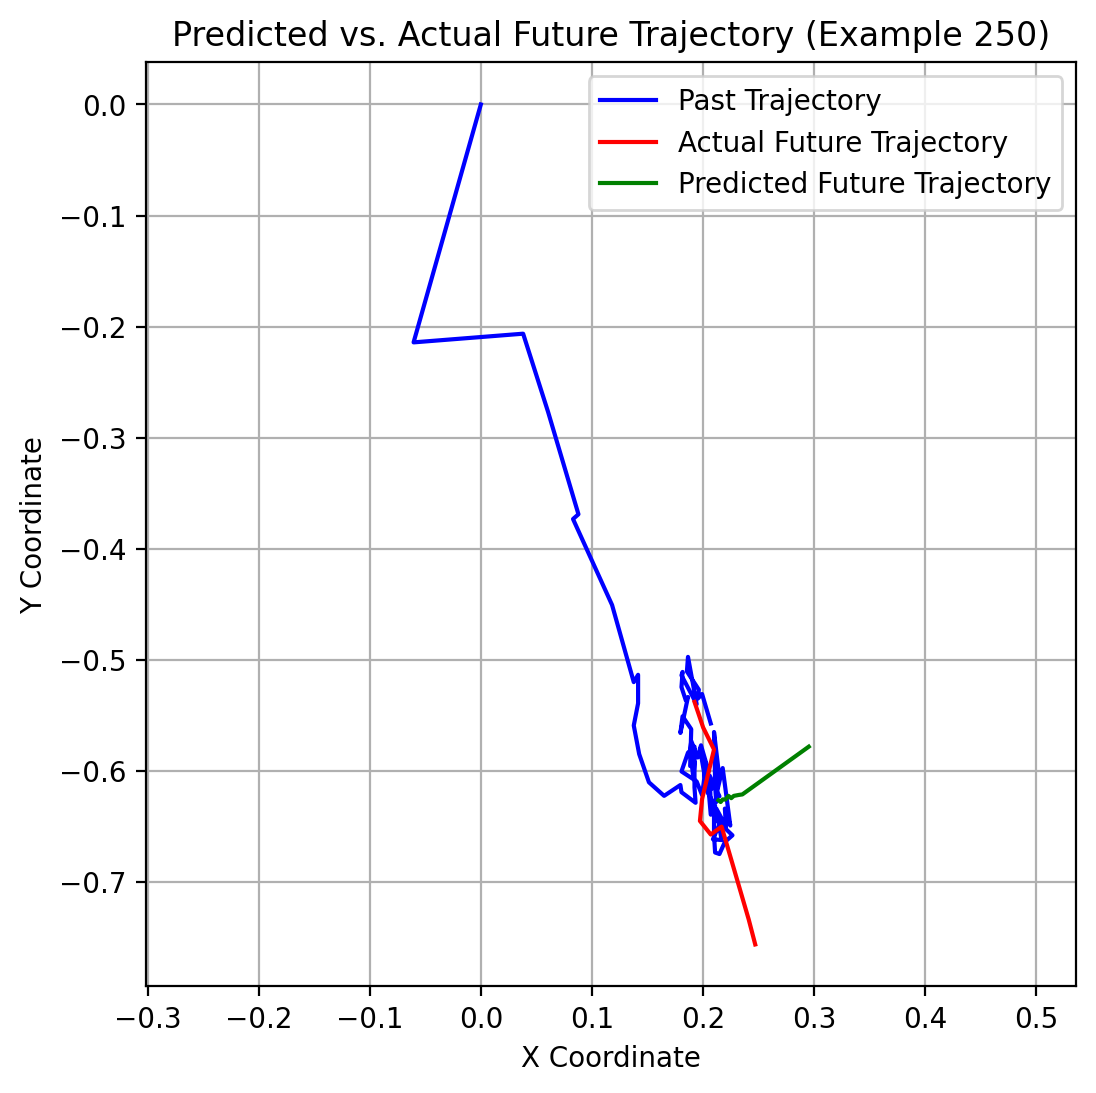

In [31]:
# import torch
# import torch.nn as nn

# class TrajectoryTransformer(nn.Module):
#     def __init__(self, input_size, model_dim, num_heads, num_layers, output_features=2, output_timesteps=10, max_seq_length=50):
#         super(TrajectoryTransformer, self).__init__()
#         self.embedding = nn.Linear(input_size, model_dim)
#         self.positional_encoding = nn.Parameter(torch.randn(max_seq_length, model_dim))
#         self.transformer = nn.Transformer(
#             d_model=model_dim,
#             nhead=num_heads,
#             num_encoder_layers=num_layers,
#             num_decoder_layers=num_layers,
#             dim_feedforward=4 * model_dim,
#             dropout=0.5 #dropout=0.1
#         )
#         self.fc = nn.Linear(model_dim, output_features * output_timesteps)
#         self.output_features = output_features
#         self.output_timesteps = output_timesteps

#     def forward(self, x):
#         # x: (batch_size, seq_length, input_size)
#         batch_size, seq_length, input_size = x.size()
#         src = self.embedding(x) + self.positional_encoding[:seq_length]  # Add positional encoding
#         src = src.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, model_dim)

#         tgt = torch.zeros_like(src)  # Dummy target (for autoregressive tasks, replace with actual decoder inputs if needed)

#         # Pass through the Transformer
#         output = self.transformer(src, tgt)
#         output = output[-1]  # Take the last sequence position
#         output = self.fc(output)
#         return output.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, 10, 2)



# class TrajectoryLoss(nn.Module):
#     def __init__(self):
#         super(TrajectoryLoss, self).__init__()
#         self.max_acceleration = 3.0

#     def forward(self, predictions, targets, last_input_state, dt=0.1):
#         # Reconstruct trajectory from velocities
#         pred_velocity = predictions[:, :, :]
#         cum_disp = torch.cumsum(pred_velocity * dt, dim=1)
#         # print(pred_velocity.shape)
#         # (32, 10, 2)
#         pred_position = cum_disp + last_input_state.unsqueeze(1)
#         # print(pred_position.shape)

#         target_position = targets[:, :, :2]
#         target_velocity = targets[:, :, 2:4]

#         # Calculate MSE for position

#         position_loss = F.mse_loss(pred_position, target_position)
#         velocity_loss = F.mse_loss(pred_velocity, target_velocity)
#         terminal_position_loss = F.mse_loss(pred_position[:, -1, :], target_position[:, -1, :]) + F.mse_loss(pred_position[:, 0, :], target_position[:, 0, :])
#         smoothness_loss = self.smoothness_loss(pred_position)

#         total_loss = position_loss + velocity_loss + smoothness_loss + 2 * terminal_position_loss
#         return total_loss

#     def acceleration_limit_loss(self, pred_velocity, dt=0.1):
#         # Ensure accelerations remain within feasible limits by penalizing large changes in velocity
#         approx_acceleration = (pred_velocity[:, :-1, :] - pred_velocity[:, 1:, :]) / dt  # Difference between consecutive velocities
#         acceleration_norm = torch.norm(approx_acceleration, dim=2)
#         excess_acceleration = torch.clamp(acceleration_norm - self.max_acceleration, min=0.0)
#         return torch.mean(excess_acceleration ** 2)


#     def smoothness_loss(self, pred_position):
#         # Calculate the difference between consecutive positions
#         diff = pred_position[:, :-1, :] - pred_position[:, 1:, :]
#         smoothness = torch.norm(diff, dim=2)
#         return torch.mean(smoothness)
# from torch.utils.data import DataLoader, TensorDataset
# import torch

# train_losses = []
# val_losses = []

# def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10):
#     criterion = TrajectoryLoss()  # Use the custom loss function
#     optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)  # Adam optimizer
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

#     for epoch in range(num_epochs):
#         model.train()  # Set the model to training mode
#         epoch_train_loss = 0  # Initialize training loss for the epoch
#         for batch_x, batch_y in train_loader:
#             batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

#             optimizer.zero_grad()  # Zero the gradients
#             outputs = model(batch_x)  # Forward pass
#             loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Compute loss using the custom loss function
#             loss.backward()  # Backward pass
#             optimizer.step()  # Update weights

#             epoch_train_loss += loss.item()  # Accumulate training loss

#         # Update learning rate based on the cosine decay schedule
#         scheduler.step()

#         # Average training loss for the epoch
#         avg_train_loss = epoch_train_loss / len(train_loader)
#         train_losses.append(avg_train_loss)  # Store training loss
#         print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

#         # Validation loop
#         model.eval()  # Set the model to evaluation mode
#         epoch_val_loss = 0  # Initialize validation loss for the epoch
#         with torch.no_grad():
#             for batch_x, batch_y in val_loader:
#                 batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

#                 outputs = model(batch_x)
#                 loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
#                 epoch_val_loss += loss.item()  # Accumulate validation loss

#             # Average validation loss for the epoch
#             avg_val_loss = epoch_val_loss / len(val_loader)
#             val_losses.append(avg_val_loss)  # Store validation loss
#             print(f'Validation Loss: {avg_val_loss:.4f}')

# # Create Tensor datasets
# train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
# val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# # Create DataLoaders
# # train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# # val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


# # Initialize model
# input_size = X_train.shape[2]  # Number of features
# hidden_size = 64  # You can adjust this

# # hidden_size = 32  # You can adjust this

# # input_size = 5
# # model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=4).to("cuda")

# model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1).to("cuda")


# # Train the model with cosine decay learning rate


# train_model(model, train_loader, val_loader, num_epochs=150, initial_lr=1e-2, T_max=50)


# x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
# y = torch.tensor(y_val, dtype=torch.float32).to("cuda")

# with torch.no_grad():
#     outputs = model(x)
#     cum_disp = torch.cumsum(outputs * 0.1, dim=1)
#     pred_position = cum_disp + y[:, 0, :2].unsqueeze(1)

#     distances = torch.norm(pred_position - y[:, :, :2], dim=2)
#     mean_ade = distances.mean().item()
# #LSTM
# print("Mean ADE:", mean_ade)



# Choose a random example from the validation dataset
example_index = 250 # np.random.randint(0, len(X_val))
# 300 produces no movement for x and y
# 250 produces an erratic motion for x and y (curvy)
# 492 -> no motion in x direction, only movement in y-direction

past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()



# Plot the past trajectory, actual future trajectory, and predicted future trajectory
#LSTM
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

# print(past_traj[:, :2])

# Bi-directional LSTM

Epoch [1/100], Training Loss: 4890.7328, LR: 0.009998
Validation Loss: 2230.0916
Epoch [2/100], Training Loss: 4033.7339, LR: 0.009990
Validation Loss: 1832.9854
Epoch [3/100], Training Loss: 3632.7713, LR: 0.009978
Validation Loss: 1689.9280
Epoch [4/100], Training Loss: 3355.8287, LR: 0.009961
Validation Loss: 1553.2470
Epoch [5/100], Training Loss: 3402.7364, LR: 0.009938
Validation Loss: 1527.8050
Epoch [6/100], Training Loss: 3171.5593, LR: 0.009911
Validation Loss: 1471.1925
Epoch [7/100], Training Loss: 3091.2307, LR: 0.009880
Validation Loss: 1471.1930
Epoch [8/100], Training Loss: 3055.4152, LR: 0.009843
Validation Loss: 1433.4408
Epoch [9/100], Training Loss: 2972.4968, LR: 0.009801
Validation Loss: 1390.3401
Epoch [10/100], Training Loss: 2871.0890, LR: 0.009755
Validation Loss: 1445.2775
Epoch [11/100], Training Loss: 2823.8497, LR: 0.009704
Validation Loss: 1360.7763
Epoch [12/100], Training Loss: 2769.0573, LR: 0.009649
Validation Loss: 1383.3707
Epoch [13/100], Training 

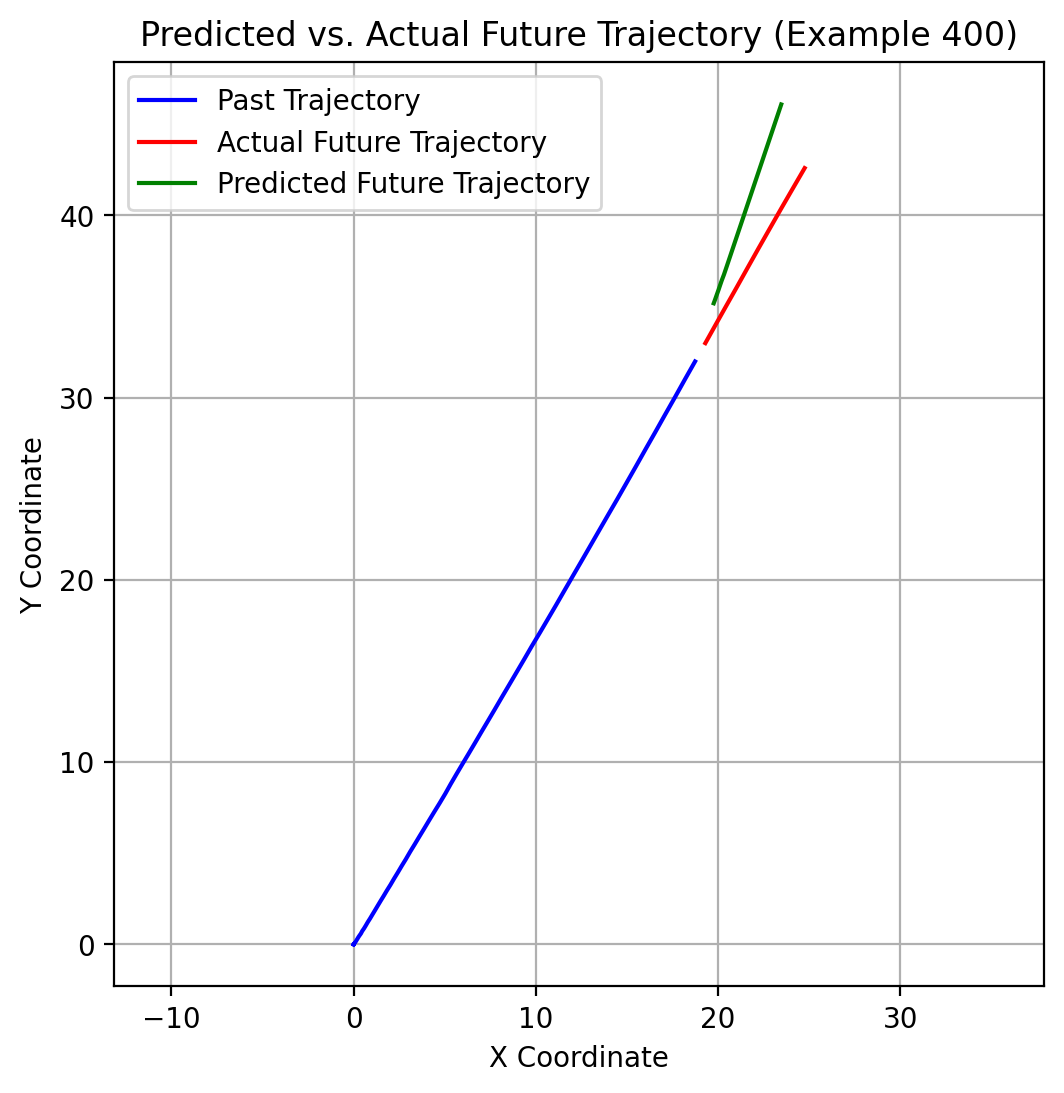

In [ ]:
#Kavya and Srishti

import torch
import torch.nn as nn

class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1):  # Set default n to 10
        super(TrajectoryLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_features * output_timesteps)
        self.output_features = output_features
        self.output_timesteps = output_timesteps

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        # _, (hn, _) = self.lstm(x)
        # # hn: (num_layers, batch_size, hidden_size)
        # # want to take the last layer so that you are left with (batch_size, hidden_size)
        # out = self.fc(hn[-1])
        # return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, 10, input_size)


        _, (hn, _) = self.lstm(x)
        # hn: (num_layers * num_directions, batch_size, hidden_size)
        hn = hn.view(self.lstm.num_layers, 2, x.size(0), self.lstm.hidden_size)  # Reshape to access both directions
        hn = torch.cat((hn[-1, 0], hn[-1, 1]), dim=-1)  # Concatenate forward and backward hidden states
        out = self.fc(hn)
        return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, output_timesteps, output_features)




class TrajectoryLoss(nn.Module):
    def __init__(self):
        super(TrajectoryLoss, self).__init__()
        self.max_acceleration = 3.0

    def forward(self, predictions, targets, last_input_state, dt=0.1):
        # Reconstruct trajectory from velocities
        pred_velocity = predictions[:, :, :]
        cum_disp = torch.cumsum(pred_velocity * dt, dim=1)
        # print(pred_velocity.shape)
        # (32, 10, 2)

        pred_position = cum_disp + last_input_state.unsqueeze(1)

        # print(pred_position.shape)

        target_position = targets[:, :, :2]
        target_velocity = targets[:, :, 2:4]

        # Calculate MSE for position

        position_loss = F.mse_loss(pred_position, target_position)

        velocity_loss = F.mse_loss(pred_velocity, target_velocity)
        terminal_position_loss = F.mse_loss(pred_position[:, -1, :], target_position[:, -1, :]) + F.mse_loss(pred_position[:, 0, :], target_position[:, 0, :])
        smoothness_loss = self.smoothness_loss(pred_position)

        total_loss = position_loss + velocity_loss + smoothness_loss + 2 * terminal_position_loss
        return total_loss

    def acceleration_limit_loss(self, pred_velocity, dt=0.1):
        # Ensure accelerations remain within feasible limits by penalizing large changes in velocity
        approx_acceleration = (pred_velocity[:, :-1, :] - pred_velocity[:, 1:, :]) / dt  # Difference between consecutive velocities
        acceleration_norm = torch.norm(approx_acceleration, dim=2)
        excess_acceleration = torch.clamp(acceleration_norm - self.max_acceleration, min=0.0)
        return torch.mean(excess_acceleration ** 2)


    def smoothness_loss(self, pred_position):
        # Calculate the difference between consecutive positions
        diff = pred_position[:, :-1, :] - pred_position[:, 1:, :]
        smoothness = torch.norm(diff, dim=2)
        return torch.mean(smoothness)



from torch.utils.data import DataLoader, TensorDataset
import torch

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10):
    criterion = TrajectoryLoss()  # Use the custom loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0  # Initialize training loss for the epoch
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Compute loss using the custom loss function
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            epoch_train_loss += loss.item()  # Accumulate training loss

        # Update learning rate based on the cosine decay schedule
        scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store training loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0  # Initialize validation loss for the epoch
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()  # Accumulate validation loss

            # Average validation loss for the epoch
            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)  # Store validation loss
            print(f'Validation Loss: {avg_val_loss:.4f}')

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model
input_size = X_train.shape[2]  # Number of features
hidden_size = 64  # You can adjust this
# input_size = 5
model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=4).to("cuda")

# Train the model with cosine decay learning rate
train_model(model, train_loader, val_loader, num_epochs=100, initial_lr=1e-2, T_max=50)


x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")

with torch.no_grad():
    outputs = model(x)
    cum_disp = torch.cumsum(outputs * 0.1, dim=1)
    pred_position = cum_disp + y[:, 0, :2].unsqueeze(1)

    distances = torch.norm(pred_position - y[:, :, :2], dim=2)
    mean_ade = distances.mean().item()
#LSTM
print("Mean ADE:", mean_ade)

# Choose a random example from the validation dataset
example_index = 400 # np.random.randint(0, len(X_val))
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# print(past_traj[:, :2])


# Plot the past trajectory, actual future trajectory, and predicted future trajectory
#LSTM
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()


# Additional Layers - eg. Dropout

Epoch [1/150], Training Loss: 5333.4229, LR: 0.009999
Validation Loss: 2192.9362
Epoch [2/150], Training Loss: 4691.6518, LR: 0.009996
Validation Loss: 1772.0045
Epoch [3/150], Training Loss: 4419.1577, LR: 0.009990
Validation Loss: 1602.6622
Epoch [4/150], Training Loss: 4325.9180, LR: 0.009982
Validation Loss: 1561.4033
Epoch [5/150], Training Loss: 4255.9501, LR: 0.009973
Validation Loss: 1491.1253
Epoch [6/150], Training Loss: 4202.7643, LR: 0.009961
Validation Loss: 1497.6391
Epoch [7/150], Training Loss: 4127.3471, LR: 0.009946
Validation Loss: 1462.8259
Epoch [8/150], Training Loss: 4240.7260, LR: 0.009930
Validation Loss: 1571.9012
Epoch [9/150], Training Loss: 4273.3892, LR: 0.009911
Validation Loss: 1580.2344
Epoch [10/150], Training Loss: 4071.7121, LR: 0.009891
Validation Loss: 1471.3118
Epoch [11/150], Training Loss: 4127.0776, LR: 0.009868
Validation Loss: 1445.7987
Epoch [12/150], Training Loss: 4133.3814, LR: 0.009843
Validation Loss: 1448.1482
Epoch [13/150], Training 

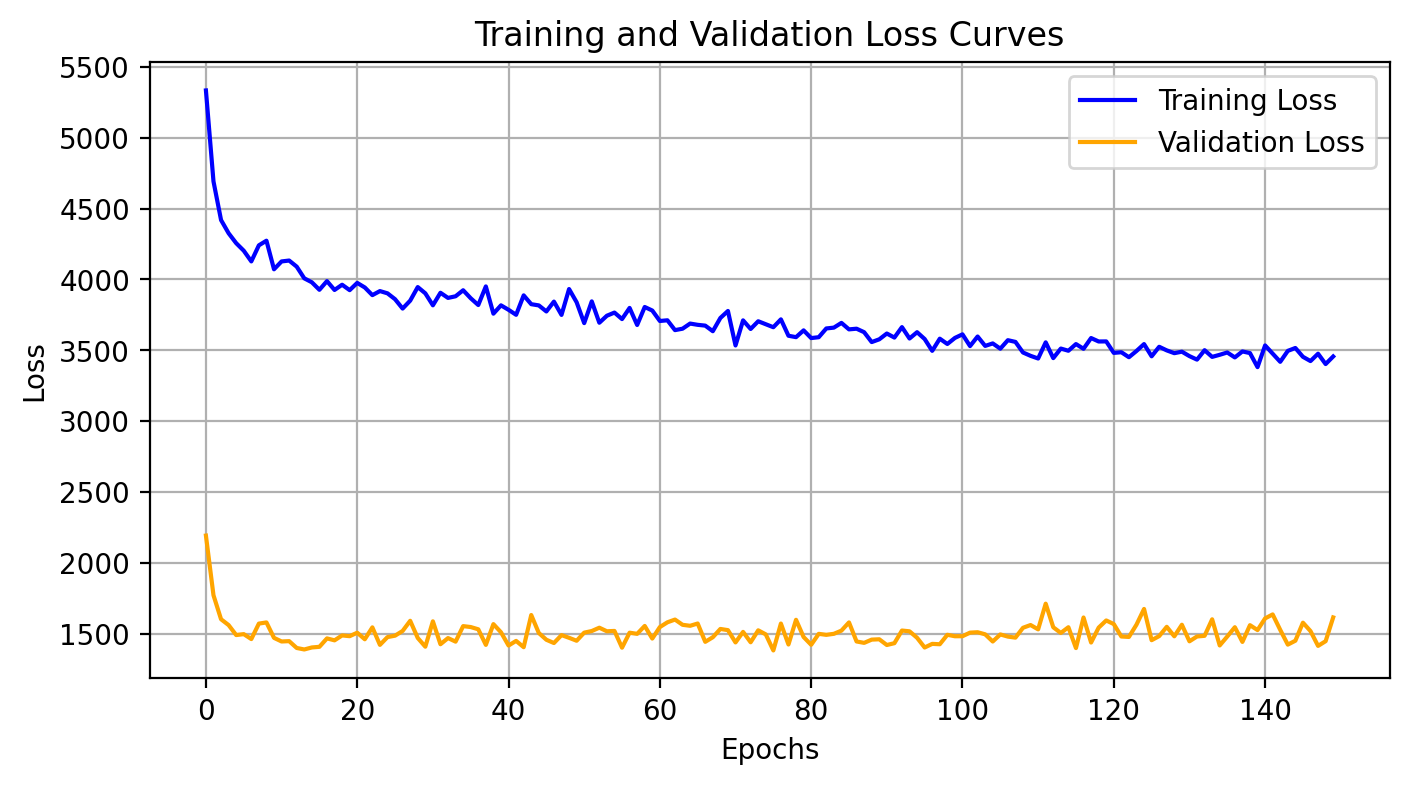

Mean ADE: 3.91568660736084


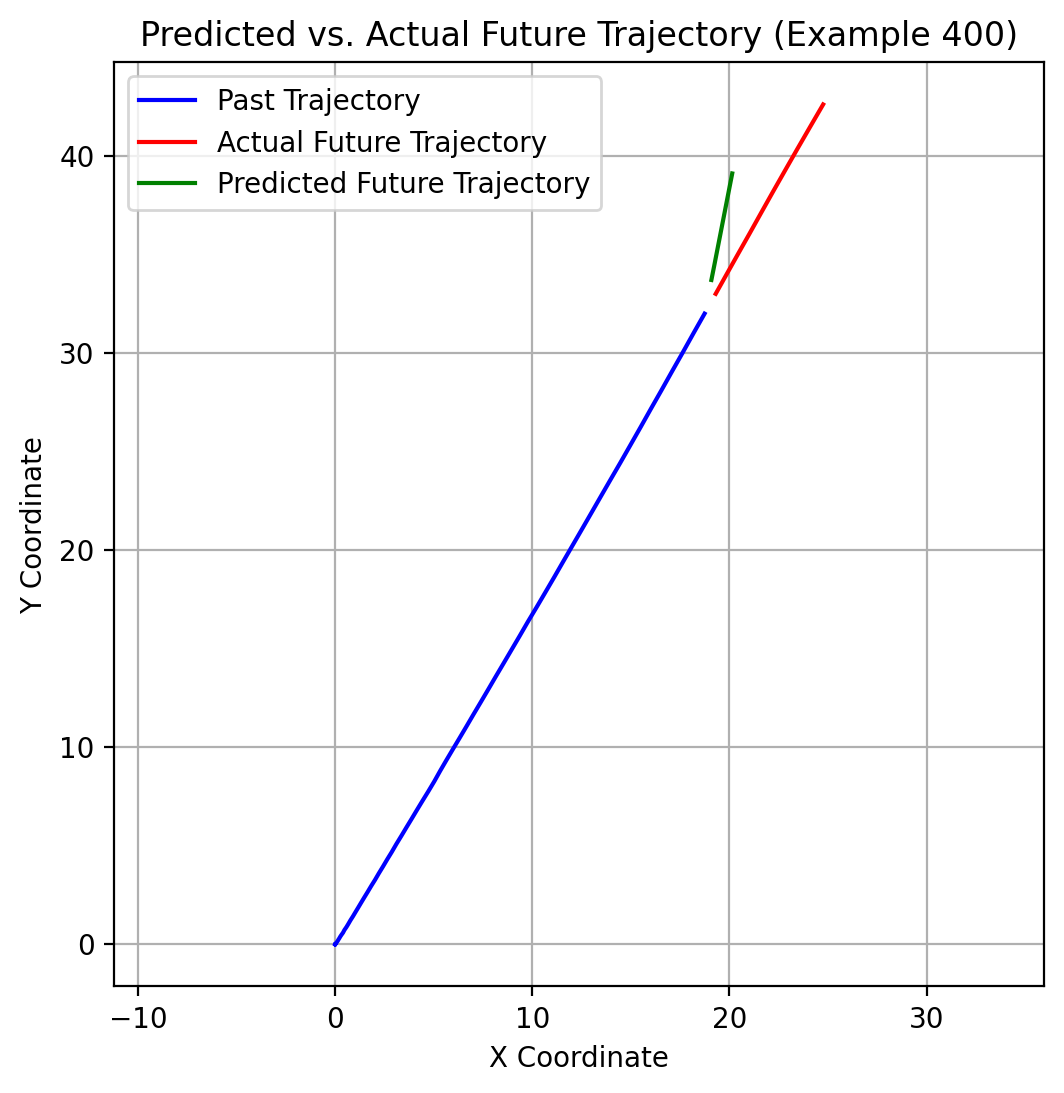

In [ ]:
#Kavya and Srishti

import torch
import torch.nn as nn

class TrajectoryLSTM(nn.Module):
    # def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1, dropout=0.2):
    #     super(TrajectoryLSTM, self).__init__()
    #     self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
    #     self.dropout = nn.Dropout(dropout)  # Dropout layer
    #     self.fc = nn.Linear(hidden_size * 2, output_features * output_timesteps)
    #     self.output_features = output_features
    #     self.output_timesteps = output_timesteps

    # def forward(self, x):
    #     # x: (batch_size, seq_length, input_size)
    #     # _, (hn, _) = self.lstm(x)
    #     # # hn: (num_layers * num_directions, batch_size, hidden_size)
    #     # hn = hn.view(self.lstm.num_layers, 2, x.size(0), self.lstm.hidden_size)  # Reshape to access both directions
    #     # hn = torch.cat((hn[-1, 0], hn[-1, 1]), dim=-1)  # Concatenate forward and backward hidden states
    #     # hn = self.dropout(hn)  # Apply dropout
    #     # out = self.fc(hn)
    #     # return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, output_timesteps, output_features)

    #     _, (hn, _) = self.lstm(x)
    #     # hn: (num_layers, batch_size, hidden_size)
    #     # want to take the last layer so that you are left with (batch_size, hidden_size)
    #     out = self.fc(hn[-1])
    #     return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, 10, input_size)

    def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1, dropout=0.2):  # Set default n to 10
        super(TrajectoryLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)  # Dropout layer
        # self.fc = nn.Linear(hidden_size, output_features * output_timesteps)
        self.fc = nn.Sequential(
          nn.Linear(hidden_size, 64),
          nn.BatchNorm1d(64),
          nn.Dropout(0.5), # Dropout after the first FC layer
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.BatchNorm1d(32),
          nn.Dropout(0.3), # Dropout after the second FC layer
          nn.ReLU(),
          nn.Linear(32, output_features * output_timesteps))
        self.output_features = output_features
        self.output_timesteps = output_timesteps

    def forward(self, x):
        # x: (batch_size, seq_length, input_size)
        _, (hn, _) = self.lstm(x)
        # hn: (num_layers, batch_size, hidden_size)
        # want to take the last layer so that you are left with (batch_size, hidden_size)
        hn = self.dropout(hn)
        out = self.fc(hn[-1])
        return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, 10, input_size)



class TrajectoryLoss(nn.Module):
    def __init__(self):
        super(TrajectoryLoss, self).__init__()
        self.max_acceleration = 3.0

    def forward(self, predictions, targets, last_input_state, dt=0.1):
        # Reconstruct trajectory from velocities
        pred_velocity = predictions[:, :, :]
        cum_disp = torch.cumsum(pred_velocity * dt, dim=1)
        # print(pred_velocity.shape)
        # (32, 10, 2)

        pred_position = cum_disp + last_input_state.unsqueeze(1)

        # print(pred_position.shape)

        target_position = targets[:, :, :2]
        target_velocity = targets[:, :, 2:4]

        # Calculate MSE for position

        position_loss = F.mse_loss(pred_position, target_position)

        velocity_loss = F.mse_loss(pred_velocity, target_velocity)
        terminal_position_loss = F.mse_loss(pred_position[:, -1, :], target_position[:, -1, :]) + F.mse_loss(pred_position[:, 0, :], target_position[:, 0, :])
        smoothness_loss = self.smoothness_loss(pred_position)

        total_loss = position_loss + velocity_loss + smoothness_loss + 2 * terminal_position_loss
        return total_loss

    def acceleration_limit_loss(self, pred_velocity, dt=0.1):
        # Ensure accelerations remain within feasible limits by penalizing large changes in velocity
        approx_acceleration = (pred_velocity[:, :-1, :] - pred_velocity[:, 1:, :]) / dt  # Difference between consecutive velocities
        acceleration_norm = torch.norm(approx_acceleration, dim=2)
        excess_acceleration = torch.clamp(acceleration_norm - self.max_acceleration, min=0.0)
        return torch.mean(excess_acceleration ** 2)


    def smoothness_loss(self, pred_position):
        # Calculate the difference between consecutive positions
        diff = pred_position[:, :-1, :] - pred_position[:, 1:, :]
        smoothness = torch.norm(diff, dim=2)
        return torch.mean(smoothness)



from torch.utils.data import DataLoader, TensorDataset
import torch

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10):
    criterion = TrajectoryLoss()  # Use the custom loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0  # Initialize training loss for the epoch
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Compute loss using the custom loss function
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            epoch_train_loss += loss.item()  # Accumulate training loss

        # Update learning rate based on the cosine decay schedule
        scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store training loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0  # Initialize validation loss for the epoch
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()  # Accumulate validation loss

            # Average validation loss for the epoch
            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)  # Store validation loss
            print(f'Validation Loss: {avg_val_loss:.4f}')

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize model
input_size = X_train.shape[2]  # Number of features
hidden_size = 64  # You can adjust this
# input_size = 5
model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1, dropout=0.5).to("cuda")

# Train the model with cosine decay learning rate
train_model(model, train_loader, val_loader, num_epochs=150, initial_lr=1e-2, T_max=50)

def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss_curves(train_losses, val_losses)

x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")

with torch.no_grad():
    outputs = model(x)
    cum_disp = torch.cumsum(outputs * 0.1, dim=1)
    pred_position = cum_disp + y[:, 0, :2].unsqueeze(1)

    distances = torch.norm(pred_position - y[:, :, :2], dim=2)
    mean_ade = distances.mean().item()
#LSTM
print("Mean ADE:", mean_ade)

# Choose a random example from the validation dataset
example_index = 400 # np.random.randint(0, len(X_val))
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# print(past_traj[:, :2])


# Plot the past trajectory, actual future trajectory, and predicted future trajectory
#LSTM
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()


# Attention Mechanism

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch [1/150], Training Loss: 5119.9174, LR: 0.009999
Validation Loss: 2154.7935
Epoch [2/150], Training Loss: 4324.3833, LR: 0.009996
Validation Loss: 1670.8843
Epoch [3/150], Training Loss: 3960.9132, LR: 0.009990
Validation Loss: 1504.5320
Epoch [4/150], Training Loss: 3879.0687, LR: 0.009982
Validation Loss: 1395.8312
Epoch [5/150], Training Loss: 3814.2472, LR: 0.009973
Validation Loss: 1477.6224
Epoch [6/150], Training Loss: 3814.0760, LR: 0.009961
Validation Loss: 1502.3920
Epoch [7/150], Training Loss: 3707.0362, LR: 0.009946
Validation Loss: 1551.7801
Epoch [8/150], Training Loss: 3627.6513, LR: 0.009930
Validation Loss: 1386.1008
Epoch [9/150], Training Loss: 3644.7664, LR: 0.009911
Validation Loss: 1384.3799
Epoch [10/150], Training Loss: 3645.7540, LR: 0.009891
Validation Loss: 1439.0469
Epoch [11/150], Training Loss: 3681.2306, LR: 0.009868
Validation Loss: 1451.8817
Epoch [12/150], Training Loss: 3554.2708, LR: 0.009843
Validation Loss: 1365.2064
Epoch [13/150], Training 

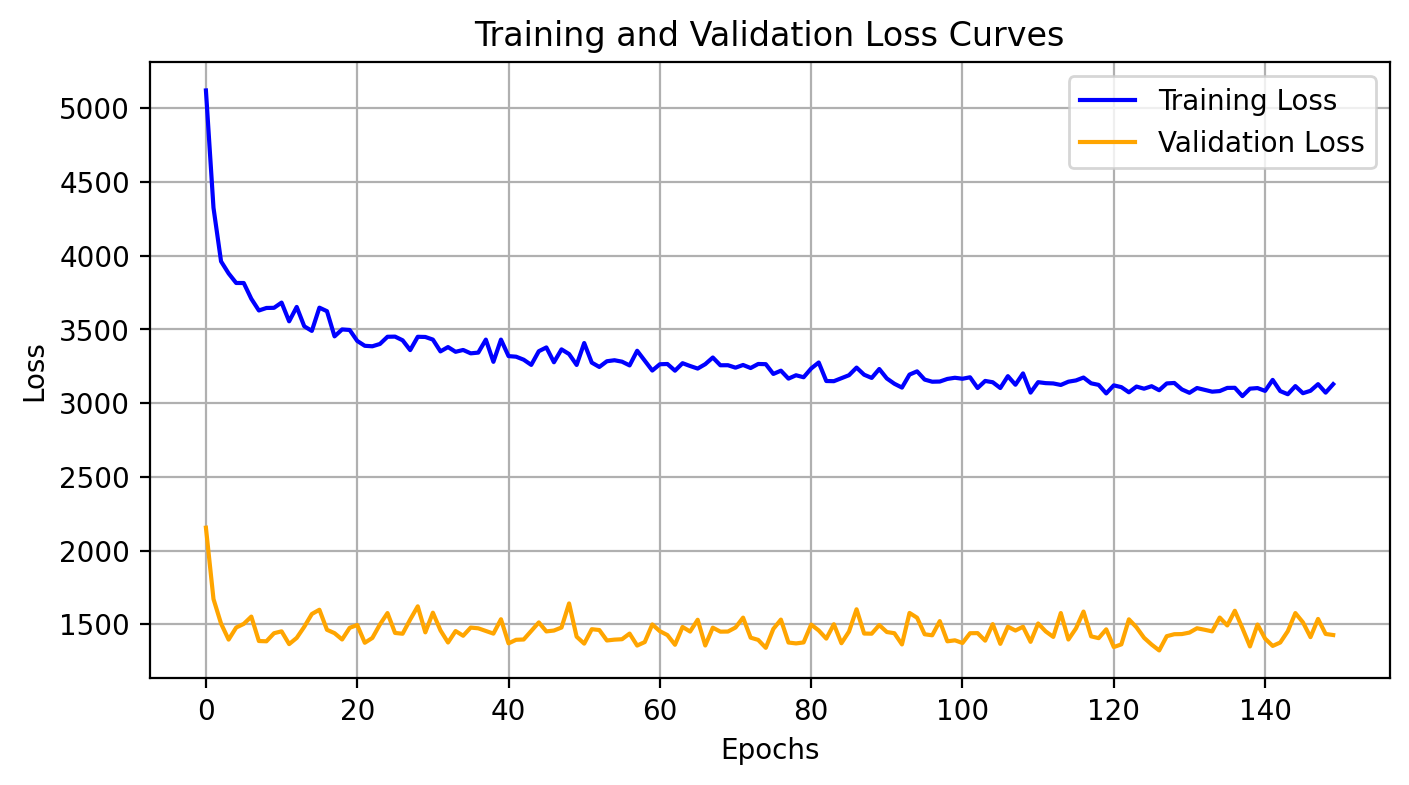

Mean ADE: 5.303923606872559


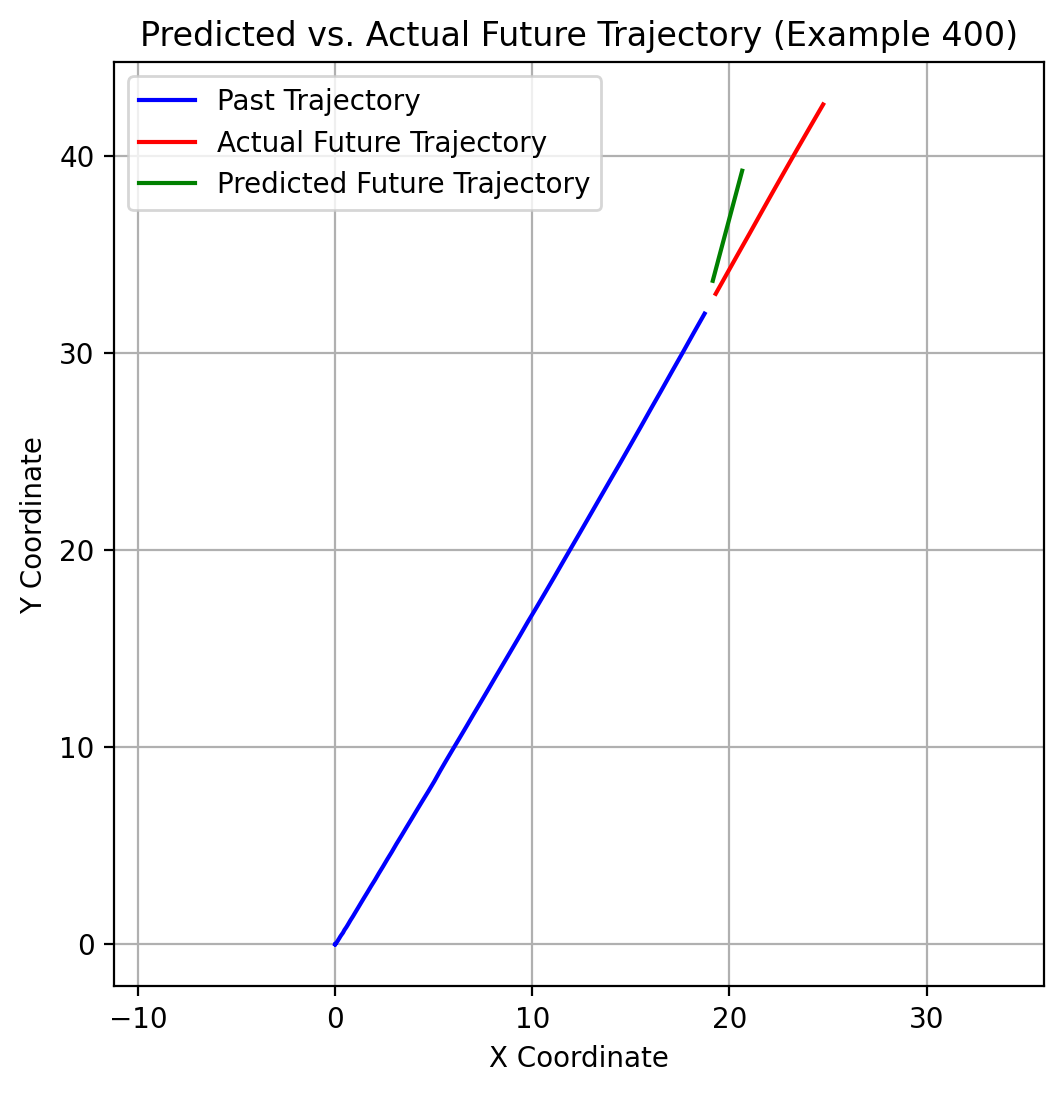

In [ ]:
#Kavya and Srishti

import torch
import torch.nn as nn

# class TrajectoryLSTM(nn.Module):
#     # def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1, dropout=0.2):
#     #     super(TrajectoryLSTM, self).__init__()
#     #     self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
#     #     self.dropout = nn.Dropout(dropout)  # Dropout layer
#     #     self.fc = nn.Linear(hidden_size * 2, output_features * output_timesteps)
#     #     self.output_features = output_features
#     #     self.output_timesteps = output_timesteps

#     # def forward(self, x):
#     #     # x: (batch_size, seq_length, input_size)
#     #     # _, (hn, _) = self.lstm(x)
#     #     # # hn: (num_layers * num_directions, batch_size, hidden_size)
#     #     # hn = hn.view(self.lstm.num_layers, 2, x.size(0), self.lstm.hidden_size)  # Reshape to access both directions
#     #     # hn = torch.cat((hn[-1, 0], hn[-1, 1]), dim=-1)  # Concatenate forward and backward hidden states
#     #     # hn = self.dropout(hn)  # Apply dropout
#     #     # out = self.fc(hn)
#     #     # return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, output_timesteps, output_features)

#     #     _, (hn, _) = self.lstm(x)
#     #     # hn: (num_layers, batch_size, hidden_size)
#     #     # want to take the last layer so that you are left with (batch_size, hidden_size)
#     #     out = self.fc(hn[-1])
#     #     return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, 10, input_size)

#     def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1, dropout=0.2):  # Set default n to 10
#         super(TrajectoryLSTM, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.dropout = nn.Dropout(dropout)  # Dropout layer
#         # self.fc = nn.Linear(hidden_size, output_features * output_timesteps)
#         self.fc = nn.Sequential(
#           nn.Linear(hidden_size, 64),
#           nn.BatchNorm1d(64),
#           nn.Dropout(0.5), # Dropout after the first FC layer
#           nn.ReLU(),
#           nn.Linear(64, 32),
#           nn.BatchNorm1d(32),
#           nn.Dropout(0.3), # Dropout after the second FC layer
#           nn.ReLU(),
#           nn.Linear(32, output_features * output_timesteps))
#         self.output_features = output_features
#         self.output_timesteps = output_timesteps

#     def forward(self, x):
#         # x: (batch_size, seq_length, input_size)
#         _, (hn, _) = self.lstm(x)
#         # hn: (num_layers, batch_size, hidden_size)
#         # want to take the last layer so that you are left with (batch_size, hidden_size)
#         hn = self.dropout(hn)
#         out = self.fc(hn[-1])
#         return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, 10, input_size)



class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(MultiHeadSelfAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

    def forward(self, x):
        # x: (batch_size, seq_length, embed_dim)
        attn_output, _ = self.attention(x, x, x)  # Self-attention mechanism
        return attn_output

class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1, dropout=0.5, num_heads=1):
        super(TrajectoryLSTM, self).__init__()

        # Transform input size to match attention embed_dim if needed
        self.input_transform = nn.Linear(input_size, 32)  # Transform input to embed_dim
        self.dropout = nn.Dropout(dropout)  # Dropout layer

        # MultiHeadSelfAttention layer
        self.attention = MultiHeadSelfAttention(embed_dim=64, num_heads=num_heads, dropout=dropout)

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        self.layer_norm = nn.LayerNorm(hidden_size)

        # Fully connected layers for final prediction
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),  # Dropout after the first FC layer
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),  # Dropout after the second FC layer
            nn.ReLU(),
            nn.Linear(32, output_features * output_timesteps)
        )
        self.output_features = output_features
        self.output_timesteps = output_timesteps

    def forward(self, x):
        # Transform input to match attention's expected embed_dim
        # transformed_x = self.input_transform(x)  # Transform input to embed_dim
        # transformed_x: (batch_size, seq_length, embed_dim)


        # attn_out: (batch_size, seq_length, embed_dim)

        lstm_out, _ = self.lstm(x)  # Pass attention output to LSTM
        attn_out = self.attention(lstm_out)  # Apply attention to transformed input
        # lstm_out: (batch_size, seq_length, hidden_size)

        lstm_out = self.layer_norm(lstm_out + attn_out)  # Apply LayerNorm to LSTM output
        lstm_out = lstm_out[:, -1, :]  # Take the last time step's LSTM output
        lstm_out = self.dropout(lstm_out)  # Apply dropout to LSTM output

        out = self.fc(lstm_out)  # Fully connected layer
        return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, output_timesteps, output_features)


class TrajectoryLoss(nn.Module):
    def __init__(self):
        super(TrajectoryLoss, self).__init__()
        self.max_acceleration = 3.0

    def forward(self, predictions, targets, last_input_state, dt=0.1):
        # Reconstruct trajectory from velocities
        pred_velocity = predictions[:, :, :]
        cum_disp = torch.cumsum(pred_velocity * dt, dim=1)
        # print(pred_velocity.shape)
        # (32, 10, 2)

        pred_position = cum_disp + last_input_state.unsqueeze(1)

        # print(pred_position.shape)

        target_position = targets[:, :, :2]
        target_velocity = targets[:, :, 2:4]

        # Calculate MSE for position

        position_loss = F.mse_loss(pred_position, target_position)

        velocity_loss = F.mse_loss(pred_velocity, target_velocity)
        terminal_position_loss = F.mse_loss(pred_position[:, -1, :], target_position[:, -1, :]) + F.mse_loss(pred_position[:, 0, :], target_position[:, 0, :])
        smoothness_loss = self.smoothness_loss(pred_position)

        total_loss = position_loss + velocity_loss + smoothness_loss + 2 * terminal_position_loss
        return total_loss

    def acceleration_limit_loss(self, pred_velocity, dt=0.1):
        # Ensure accelerations remain within feasible limits by penalizing large changes in velocity
        approx_acceleration = (pred_velocity[:, :-1, :] - pred_velocity[:, 1:, :]) / dt  # Difference between consecutive velocities
        acceleration_norm = torch.norm(approx_acceleration, dim=2)
        excess_acceleration = torch.clamp(acceleration_norm - self.max_acceleration, min=0.0)
        return torch.mean(excess_acceleration ** 2)


    def smoothness_loss(self, pred_position):
        # Calculate the difference between consecutive positions
        diff = pred_position[:, :-1, :] - pred_position[:, 1:, :]
        smoothness = torch.norm(diff, dim=2)
        return torch.mean(smoothness)



from torch.utils.data import DataLoader, TensorDataset
import torch

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10, freeze_attention_epochs=20):
    criterion = TrajectoryLoss()  # Use the custom loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # for param in model.attention.parameters():
    #   param.requires_grad = False

    for epoch in range(num_epochs):
      # if epoch == freeze_attention_epochs:
      #   for param in model.attention.parameters():
          # param.requires_grad = True
      model.train()  # Set the model to training mode
      epoch_train_loss = 0  # Initialize training loss for the epoch
      for batch_x, batch_y in train_loader:
          batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

          optimizer.zero_grad()  # Zero the gradients
          outputs = model(batch_x)  # Forward pass
          loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Compute loss using the custom loss function
          loss.backward()  # Backward pass
          optimizer.step()  # Update weights

          epoch_train_loss += loss.item()  # Accumulate training loss

      # Update learning rate based on the cosine decay schedule
      scheduler.step()

      # Average training loss for the epoch
      avg_train_loss = epoch_train_loss / len(train_loader)
      train_losses.append(avg_train_loss)  # Store training loss
      print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

      # Validation loop
      model.eval()  # Set the model to evaluation mode
      epoch_val_loss = 0  # Initialize validation loss for the epoch
      with torch.no_grad():
          for batch_x, batch_y in val_loader:
              batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

              outputs = model(batch_x)
              loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
              epoch_val_loss += loss.item()  # Accumulate validation loss

          # Average validation loss for the epoch
          avg_val_loss = epoch_val_loss / len(val_loader)
          val_losses.append(avg_val_loss)  # Store validation loss
          print(f'Validation Loss: {avg_val_loss:.4f}')

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize model
input_size = X_train.shape[2]  # Number of features
hidden_size = 64  # You can adjust this
# input_size = 5
model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1, dropout=0.5).to("cuda")

# Train the model with cosine decay learning rate
train_model(model, train_loader, val_loader, num_epochs=150, initial_lr=1e-2, T_max=50)

def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss_curves(train_losses, val_losses)

x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")

with torch.no_grad():
    outputs = model(x)
    cum_disp = torch.cumsum(outputs * 0.1, dim=1)
    pred_position = cum_disp + y[:, 0, :2].unsqueeze(1)

    distances = torch.norm(pred_position - y[:, :, :2], dim=2)
    mean_ade = distances.mean().item()
#LSTM
print("Mean ADE:", mean_ade)

# Choose a random example from the validation dataset
example_index = 400 # np.random.randint(0, len(X_val))
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# print(past_traj[:, :2])


# Plot the past trajectory, actual future trajectory, and predicted future trajectory
#LSTM
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()


Epoch [1/150], Training Loss: 7370.4976, LR: 0.009999
Validation Loss: 2441.3785
Epoch [2/150], Training Loss: 5720.2106, LR: 0.009996
Validation Loss: 1915.1424
Epoch [3/150], Training Loss: 5157.0871, LR: 0.009990
Validation Loss: 1766.5064
Epoch [4/150], Training Loss: 4848.8668, LR: 0.009982
Validation Loss: 1467.0901
Epoch [5/150], Training Loss: 4536.1559, LR: 0.009973
Validation Loss: 1594.7897
Epoch [6/150], Training Loss: 4388.8484, LR: 0.009961
Validation Loss: 1262.6636
Epoch [7/150], Training Loss: 4110.5111, LR: 0.009946
Validation Loss: 1413.1295
Epoch [8/150], Training Loss: 4221.5531, LR: 0.009930
Validation Loss: 1333.7783
Epoch [9/150], Training Loss: 4091.8096, LR: 0.009911
Validation Loss: 1504.9207
Epoch [10/150], Training Loss: 4016.9884, LR: 0.009891
Validation Loss: 2038.0468
Epoch [11/150], Training Loss: 4209.0516, LR: 0.009868
Validation Loss: 1546.6342
Epoch [12/150], Training Loss: 3775.1805, LR: 0.009843
Validation Loss: 1167.4586
Epoch [13/150], Training 

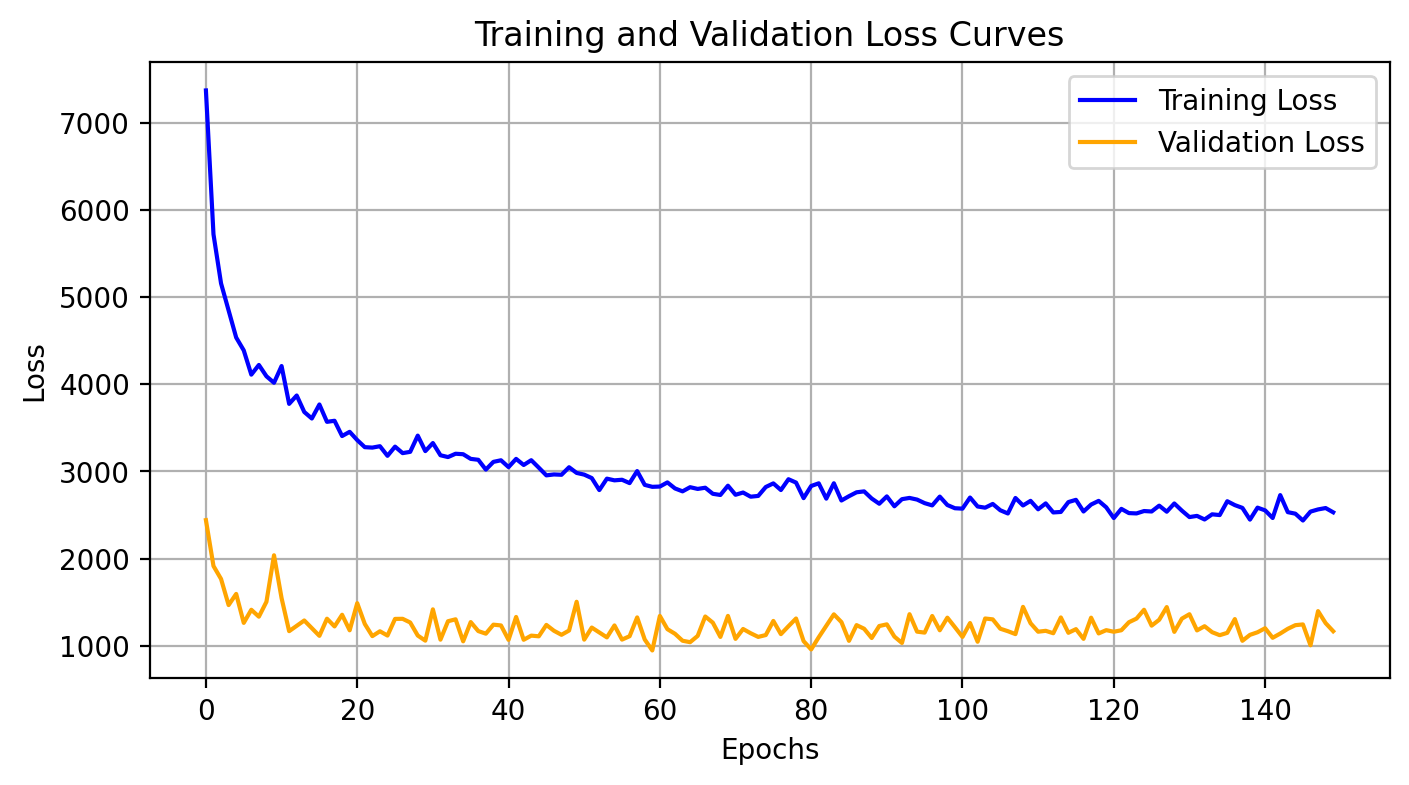

Mean ADE: 3.921842336654663


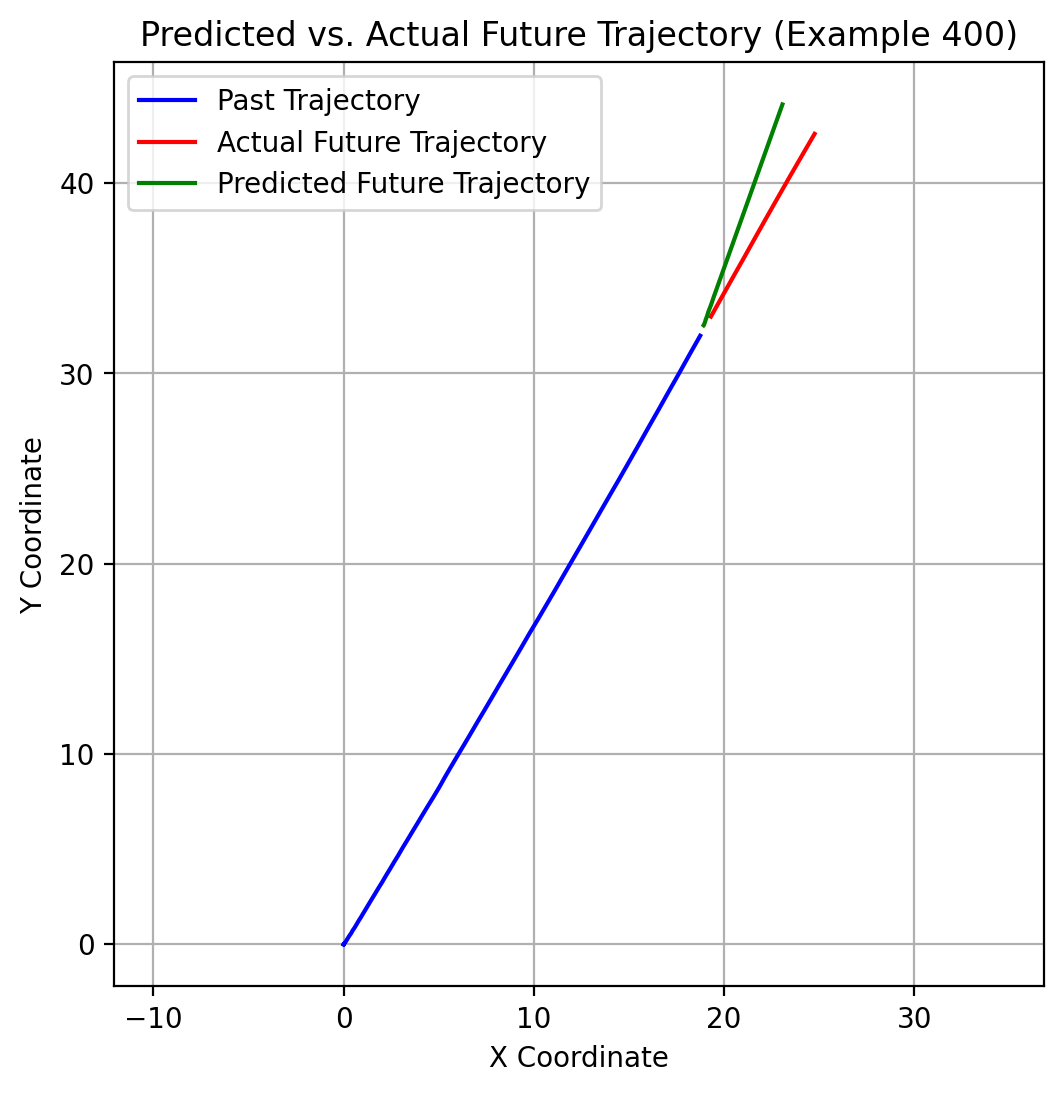

In [ ]:
#Kavya and Srishti

import torch
import torch.nn as nn

class TrajectoryLSTM(nn.Module):
    # def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1, dropout=0.2):
    #     super(TrajectoryLSTM, self).__init__()
    #     self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
    #     self.dropout = nn.Dropout(dropout)  # Dropout layer
    #     self.fc = nn.Linear(hidden_size * 2, output_features * output_timesteps)
    #     self.output_features = output_features
    #     self.output_timesteps = output_timesteps

    # def forward(self, x):
    #     # x: (batch_size, seq_length, input_size)
    #     # _, (hn, _) = self.lstm(x)
    #     # # hn: (num_layers * num_directions, batch_size, hidden_size)
    #     # hn = hn.view(self.lstm.num_layers, 2, x.size(0), self.lstm.hidden_size)  # Reshape to access both directions
    #     # hn = torch.cat((hn[-1, 0], hn[-1, 1]), dim=-1)  # Concatenate forward and backward hidden states
    #     # hn = self.dropout(hn)  # Apply dropout
    #     # out = self.fc(hn)
    #     # return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, output_timesteps, output_features)

    #     _, (hn, _) = self.lstm(x)
    #     # hn: (num_layers, batch_size, hidden_size)
    #     # want to take the last layer so that you are left with (batch_size, hidden_size)
    #     out = self.fc(hn[-1])
    #     return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, 10, input_size)

    def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1, dropout=0.5):  # Set default n to 10
        super(TrajectoryLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)  # Dropout layer
        # self.fc = nn.Linear(hidden_size, output_features * output_timesteps)
        # Single-head attention
        self.attention = nn.Linear(hidden_size, 1)  # To compute attention scores
        self.softmax = nn.Softmax(dim=1)  # For normalizing attention scores

        self.fc = nn.Sequential(
          nn.Linear(hidden_size, 64),
          nn.BatchNorm1d(64),
          nn.Dropout(0.3), # Dropout after the first FC layer
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.BatchNorm1d(32),
          nn.Dropout(0.3), # Dropout after the second FC layer
          nn.ReLU(),
          nn.Linear(32, output_features * output_timesteps))
        self.output_features = output_features
        self.output_timesteps = output_timesteps

    def forward(self, x):
        # LSTM forward pass
        lstm_out, (hn, _) = self.lstm(x)
        # lstm_out: (batch_size, seq_length, hidden_size)

        # Compute attention scores
        attn_scores = self.attention(lstm_out)  # (batch_size, seq_length, 1)
        attn_weights = self.softmax(attn_scores)  # Normalize to get weights

        # Apply attention weights to LSTM outputs
        weighted_output = lstm_out * attn_weights  # (batch_size, seq_length, hidden_size)
        context_vector = torch.sum(weighted_output, dim=1)  # Sum across seq_length

        # Apply dropout and fully connected layers
        context_vector = self.dropout(context_vector)
        out = self.fc(context_vector)  # (batch_size, output_timesteps * output_features)
        return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, output_timesteps, output_features)



class TrajectoryLoss(nn.Module):
    def __init__(self):
        super(TrajectoryLoss, self).__init__()
        self.max_acceleration = 3.0

    def forward(self, predictions, targets, last_input_state, dt=0.2):
        # Reconstruct trajectory from velocities
        pred_velocity = predictions[:, :, :]
        cum_disp = torch.cumsum(pred_velocity * dt, dim=1)
        # print(pred_velocity.shape)
        # (32, 10, 2)

        pred_position = cum_disp + last_input_state.unsqueeze(1)

        # print(pred_position.shape)

        target_position = targets[:, :, :2]
        target_velocity = targets[:, :, 2:4]

        # Calculate MSE for position

        position_loss = F.mse_loss(pred_position, target_position)

        velocity_loss = F.mse_loss(pred_velocity, target_velocity)
        terminal_position_loss = F.mse_loss(pred_position[:, -1, :], target_position[:, -1, :]) + F.mse_loss(pred_position[:, 0, :], target_position[:, 0, :])
        smoothness_loss = self.smoothness_loss(pred_position)

        # total_loss = position_loss + velocity_loss + smoothness_loss + 2 * terminal_position_loss
        total_loss = 2 * position_loss + velocity_loss + 0.5 * smoothness_loss + 3 * terminal_position_loss

        return total_loss

    def acceleration_limit_loss(self, pred_velocity, dt=0.1):
        # Ensure accelerations remain within feasible limits by penalizing large changes in velocity
        approx_acceleration = (pred_velocity[:, :-1, :] - pred_velocity[:, 1:, :]) / dt  # Difference between consecutive velocities
        acceleration_norm = torch.norm(approx_acceleration, dim=2)
        excess_acceleration = torch.clamp(acceleration_norm - self.max_acceleration, min=0.0)
        return torch.mean(excess_acceleration ** 2)


    def smoothness_loss(self, pred_position):
        # Calculate the difference between consecutive positions
        diff = pred_position[:, :-1, :] - pred_position[:, 1:, :]
        smoothness = torch.norm(diff, dim=2)
        return torch.mean(smoothness)



from torch.utils.data import DataLoader, TensorDataset
import torch

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10):
    criterion = TrajectoryLoss()  # Use the custom loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0  # Initialize training loss for the epoch
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Compute loss using the custom loss function
            loss.backward()  # Backward pass
            # added this to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3)

            optimizer.step()  # Update weights

            epoch_train_loss += loss.item()  # Accumulate training loss

        # Update learning rate based on the cosine decay schedule
        scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store training loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0  # Initialize validation loss for the epoch
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()  # Accumulate validation loss

            # Average validation loss for the epoch
            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)  # Store validation loss
            print(f'Validation Loss: {avg_val_loss:.4f}')

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize model
input_size = X_train.shape[2]  # Number of features
hidden_size = 128  # You can adjust this
# input_size = 5
model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=2, dropout=0.5).to("cuda")

# Train the model with cosine decay learning rate
train_model(model, train_loader, val_loader, num_epochs=150, initial_lr=1e-2, T_max=50)

def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss_curves(train_losses, val_losses)

x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")

with torch.no_grad():
    outputs = model(x)
    cum_disp = torch.cumsum(outputs * 0.1, dim=1)
    pred_position = cum_disp + y[:, 0, :2].unsqueeze(1)

    distances = torch.norm(pred_position - y[:, :, :2], dim=2)
    mean_ade = distances.mean().item()
#LSTM
print("Mean ADE:", mean_ade)

# Choose a random example from the validation dataset
example_index = 400 # np.random.randint(0, len(X_val))
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# print(past_traj[:, :2])


# Plot the past trajectory, actual future trajectory, and predicted future trajectory
#LSTM
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()


# Positional Encoding

Epoch [1/150], Training Loss: 5289.4887, LR: 0.009999
Validation Loss: 1636.1599
Epoch [2/150], Training Loss: 4149.5952, LR: 0.009996
Validation Loss: 1433.9795
Epoch [3/150], Training Loss: 3784.9435, LR: 0.009990
Validation Loss: 1102.7492
Epoch [4/150], Training Loss: 3716.4420, LR: 0.009982
Validation Loss: 972.8924
Epoch [5/150], Training Loss: 3428.2723, LR: 0.009973
Validation Loss: 946.1836
Epoch [6/150], Training Loss: 3351.7827, LR: 0.009961
Validation Loss: 913.1192
Epoch [7/150], Training Loss: 3171.9729, LR: 0.009946
Validation Loss: 940.5769
Epoch [8/150], Training Loss: 3199.8398, LR: 0.009930
Validation Loss: 966.4281
Epoch [9/150], Training Loss: 3121.2874, LR: 0.009911
Validation Loss: 853.4400
Epoch [10/150], Training Loss: 3126.4893, LR: 0.009891
Validation Loss: 1263.0090
Epoch [11/150], Training Loss: 3074.5009, LR: 0.009868
Validation Loss: 881.1359
Epoch [12/150], Training Loss: 2872.2339, LR: 0.009843
Validation Loss: 994.0402
Epoch [13/150], Training Loss: 28

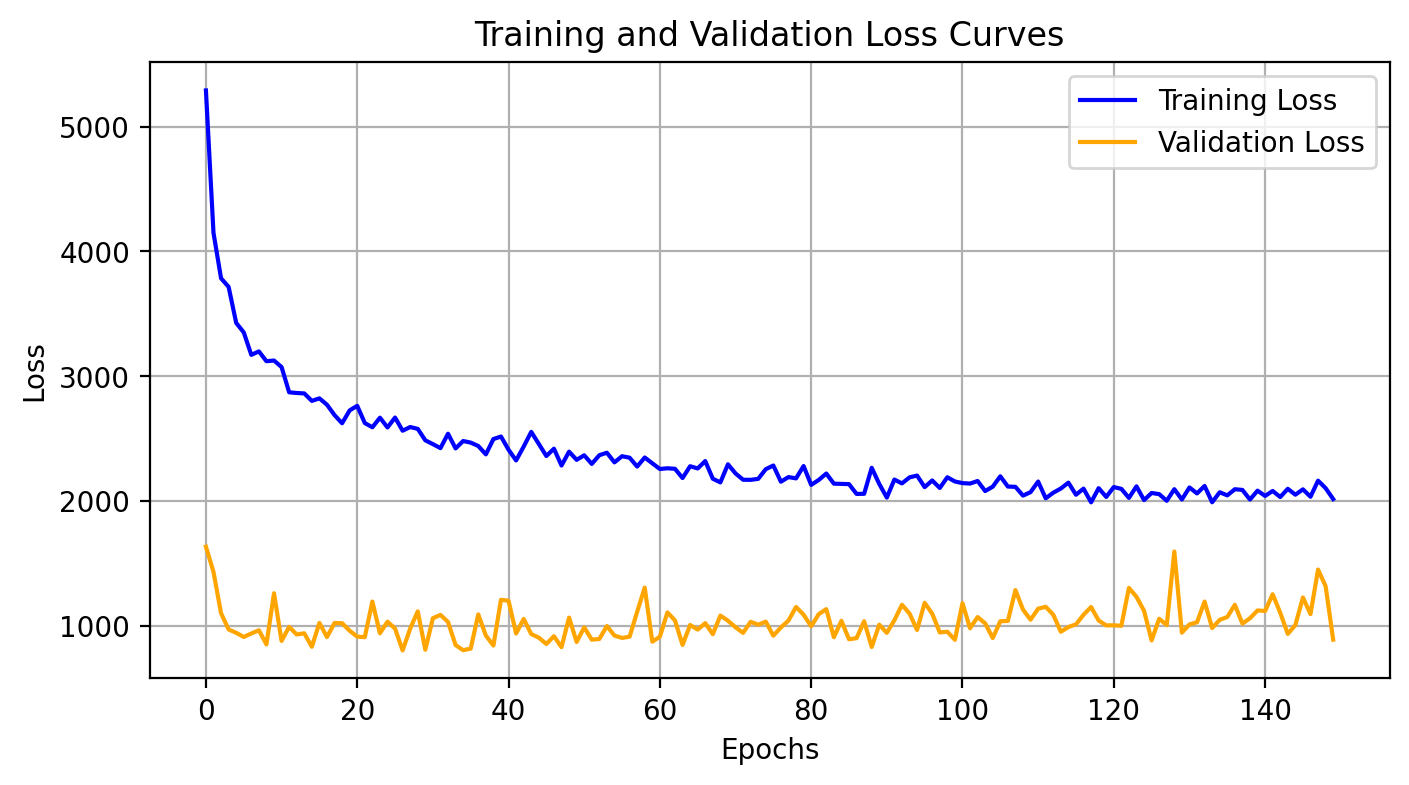

Mean ADE: 4.115090370178223


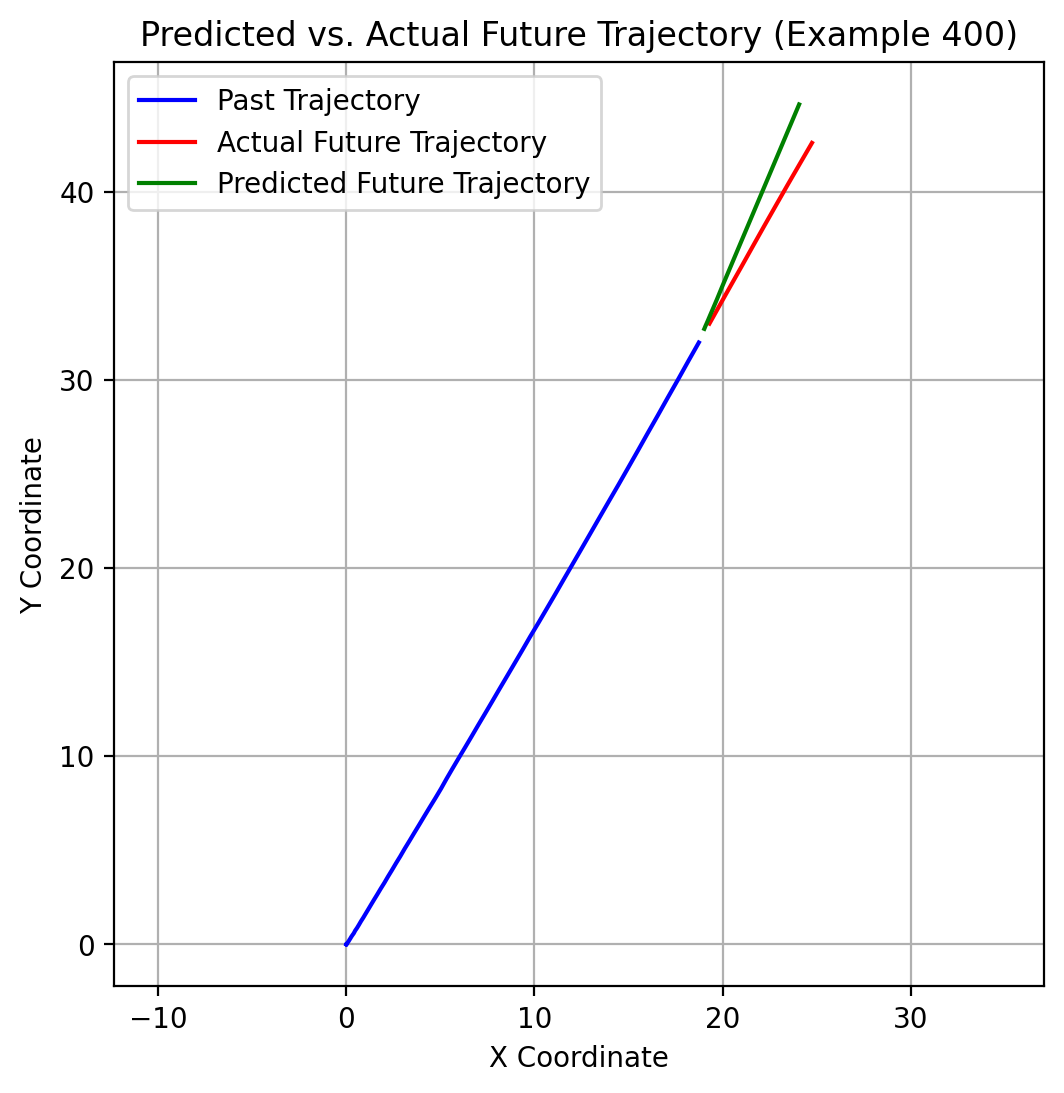

In [ ]:
#Kavya and Srishti

import math
import torch
import torch.nn as nn

class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1, dropout=0.5):
        super(TrajectoryLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_features = output_features
        self.output_timesteps = output_timesteps
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)  # Dropout layer

        # Attention mechanism
        self.attention = nn.Linear(hidden_size, 1)  # To compute attention scores
        self.softmax = nn.Softmax(dim=1)  # For normalizing attention scores

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(32, output_features * output_timesteps)
        )

    def positional_encoding(self, seq_length, dim):
        # Create the positional encoding matrix
        pos = torch.arange(seq_length, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(dim, dtype=torch.float32).unsqueeze(0)

        # Compute sinusoidal functions
        angle_rates = 1 / (10000 ** (2 * (i // 2) / dim))
        angle_rads = pos * angle_rates

        # Apply sin to even indices and cos to odd indices
        pos_enc = torch.zeros((seq_length, dim))
        pos_enc[:, 0::2] = torch.sin(angle_rads[:, 0::2])  # sin for even indices
        pos_enc[:, 1::2] = torch.cos(angle_rads[:, 1::2])  # cos for odd indices

        return pos_enc

    def forward(self, x):
        batch_size, seq_length, _ = x.size()

        # Add positional encoding
        pos_enc = self.positional_encoding(seq_length, self.input_size).to(x.device)
        x = x + pos_enc.unsqueeze(0)  # Broadcast to batch size

        # LSTM forward pass
        lstm_out, (hn, _) = self.lstm(x)

        # Compute attention scores
        attn_scores = self.attention(lstm_out)  # (batch_size, seq_length, 1)
        attn_weights = self.softmax(attn_scores)  # Normalize to get weights

        # Apply attention weights to LSTM outputs
        weighted_output = lstm_out * attn_weights  # (batch_size, seq_length, hidden_size)
        context_vector = torch.sum(weighted_output, dim=1)  # Sum across seq_length

        # Apply dropout and fully connected layers
        context_vector = self.dropout(context_vector)
        out = self.fc(context_vector)  # (batch_size, output_timesteps * output_features)
        return out.view(-1, self.output_timesteps, self.output_features)  # Reshape to (batch_size, output_timesteps, output_features)


class TrajectoryLoss(nn.Module):
    def __init__(self):
        super(TrajectoryLoss, self).__init__()
        self.max_acceleration = 3.0

    def forward(self, predictions, targets, last_input_state, dt=0.2):
        # Reconstruct trajectory from velocities
        pred_velocity = predictions[:, :, :]
        cum_disp = torch.cumsum(pred_velocity * dt, dim=1)
        # print(pred_velocity.shape)
        # (32, 10, 2)

        pred_position = cum_disp + last_input_state.unsqueeze(1)

        # print(pred_position.shape)

        target_position = targets[:, :, :2]
        target_velocity = targets[:, :, 2:4]

        # Calculate MSE for position

        position_loss = F.mse_loss(pred_position, target_position)

        velocity_loss = F.mse_loss(pred_velocity, target_velocity)
        terminal_position_loss = F.mse_loss(pred_position[:, -1, :], target_position[:, -1, :]) + F.mse_loss(pred_position[:, 0, :], target_position[:, 0, :])
        smoothness_loss = self.smoothness_loss(pred_position)

        # total_loss = position_loss + velocity_loss + smoothness_loss + 2 * terminal_position_loss
        total_loss = 2 * position_loss + velocity_loss + 0.5 * smoothness_loss + 2 * terminal_position_loss

        return total_loss

    def acceleration_limit_loss(self, pred_velocity, dt=0.1):
        # Ensure accelerations remain within feasible limits by penalizing large changes in velocity
        approx_acceleration = (pred_velocity[:, :-1, :] - pred_velocity[:, 1:, :]) / dt  # Difference between consecutive velocities
        acceleration_norm = torch.norm(approx_acceleration, dim=2)
        excess_acceleration = torch.clamp(acceleration_norm - self.max_acceleration, min=0.0)
        return torch.mean(excess_acceleration ** 2)


    def smoothness_loss(self, pred_position):
        # Calculate the difference between consecutive positions
        diff = pred_position[:, :-1, :] - pred_position[:, 1:, :]
        smoothness = torch.norm(diff, dim=2)
        return torch.mean(smoothness)



from torch.utils.data import DataLoader, TensorDataset
import torch

train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs=10, initial_lr=0.001, T_max=10):
    criterion = TrajectoryLoss()  # Use the custom loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)  # Adam optimizer
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_train_loss = 0  # Initialize training loss for the epoch
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_x)  # Forward pass
            loss = criterion(outputs, batch_y, batch_x[:, 0, :2])  # Compute loss using the custom loss function
            loss.backward()  # Backward pass
            # added this to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=3)

            optimizer.step()  # Update weights

            epoch_train_loss += loss.item()  # Accumulate training loss

        # Update learning rate based on the cosine decay schedule
        scheduler.step()

        # Average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store training loss
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        epoch_val_loss = 0  # Initialize validation loss for the epoch
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")  # Move data to GPU

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y, batch_x[:, 0, :2])
                epoch_val_loss += loss.item()  # Accumulate validation loss

            # Average validation loss for the epoch
            avg_val_loss = epoch_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)  # Store validation loss
            print(f'Validation Loss: {avg_val_loss:.4f}')

# Create Tensor datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize model
input_size = X_train.shape[2]  # Number of features
hidden_size = 128  # You can adjust this
# input_size = 5
model = TrajectoryLSTM(input_size, hidden_size, output_features=2, output_timesteps=10, num_layers=1, dropout=0.5).to("cuda")

# Train the model with cosine decay learning rate
train_model(model, train_loader, val_loader, num_epochs=150, initial_lr=1e-2, T_max=50)

def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

plot_loss_curves(train_losses, val_losses)

x = torch.tensor(X_val, dtype=torch.float32).to("cuda")
y = torch.tensor(y_val, dtype=torch.float32).to("cuda")

with torch.no_grad():
    outputs = model(x)
    cum_disp = torch.cumsum(outputs * 0.1, dim=1)
    pred_position = cum_disp + y[:, 0, :2].unsqueeze(1)

    distances = torch.norm(pred_position - y[:, :, :2], dim=2)
    mean_ade = distances.mean().item()
#LSTM
print("Mean ADE:", mean_ade)

# Choose a random example from the validation dataset
example_index = 400 # np.random.randint(0, len(X_val))
past_traj = X_val[example_index]
future_traj = y_val[example_index]

# Get the predicted future trajectory
with torch.no_grad():
  model.eval()
  X = torch.tensor(past_traj[np.newaxis, :, :], dtype=torch.float32).to("cuda")
  predicted_vels = model(X)

  predicted_vels = predicted_vels[0]
  cum_disp = torch.cumsum(predicted_vels * 0.1, dim=1)
  future_pred = cum_disp + X[0, -1, :2]
  future_pred = future_pred.cpu().numpy()

# print(past_traj[:, :2])


# Plot the past trajectory, actual future trajectory, and predicted future trajectory
#LSTM
plt.figure(figsize=(6, 6))
plt.plot(past_traj[:, 0], past_traj[:, 1], label='Past Trajectory', color='blue')
plt.plot(future_traj[:, 0], future_traj[:, 1], label='Actual Future Trajectory', color='red')
plt.plot(future_pred[:, 0], future_pred[:, 1], label='Predicted Future Trajectory', color='green')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title(f"Predicted vs. Actual Future Trajectory (Example {example_index})")
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()
